In [3]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary



# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)



## Load the MNIST-Data

In [ ]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



In [2]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)


## Partitioning the Data (IID and non-IID)

In [4]:
def iid_partition(dataset, clients):
  """
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [5]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict





## Models

In [6]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

### Print Model Summaries

In [1]:
# mnist_mlp = MNIST_2NN()

# if torch.cuda.is_available():
#   mnist_mlp.cuda()
#   mnist_cnn.cuda()





## Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [ ]:
def training(model, rounds, batch_size, lr, ds, data_dict, C, K, E, plt_title, plt_color):
  """

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []
  
  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

  end = time.time()
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Nbr of Communication Rounds', ylabel='Trainning Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

## Testing Loop

In [ ]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  for i in range(10):
    if total_class[i]>0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

## MNIST 2NN on IID

### Train E=5

Round: 1... 	Average Loss: 0.646
Round: 2... 	Average Loss: 0.173
Round: 3... 	Average Loss: 0.131
Round: 4... 	Average Loss: 0.116
Round: 5... 	Average Loss: 0.097
Round: 6... 	Average Loss: 0.081
Round: 7... 	Average Loss: 0.065
Round: 8... 	Average Loss: 0.071
Round: 9... 	Average Loss: 0.064
Round: 10... 	Average Loss: 0.062
Round: 11... 	Average Loss: 0.053
Round: 12... 	Average Loss: 0.054
Round: 13... 	Average Loss: 0.048
Round: 14... 	Average Loss: 0.043
Round: 15... 	Average Loss: 0.042
Round: 16... 	Average Loss: 0.047
Round: 17... 	Average Loss: 0.036
Round: 18... 	Average Loss: 0.038
Round: 19... 	Average Loss: 0.038
Round: 20... 	Average Loss: 0.038
Round: 21... 	Average Loss: 0.035
Round: 22... 	Average Loss: 0.039
Round: 23... 	Average Loss: 0.03
Round: 24... 	Average Loss: 0.034
Round: 25... 	Average Loss: 0.031
Round: 26... 	Average Loss: 0.031
Round: 27... 	Average Loss: 0.03
Round: 28... 	Average Loss: 0.026
Round: 29... 	Average Loss: 0.03
Round: 30... 	Average Loss

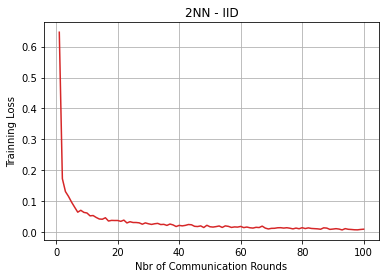

In [ ]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each round
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.03
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "2NN - IID", "red")


### Test

In [ ]:
criterion = nn.CrossEntropyLoss()
testing(mnist_mlp_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.072560

Test Accuracy of     0: 97% (74/76)
Test Accuracy of     1: 96% (87/90)
Test Accuracy of     2: 97% (89/91)
Test Accuracy of     3: 98% (72/73)
Test Accuracy of     4: 98% (88/89)
Test Accuracy of     5: 97% (66/68)
Test Accuracy of     6: 95% (59/62)
Test Accuracy of     7: 97% (79/81)
Test Accuracy of     8: 100% (77/77)
Test Accuracy of     9: 100% (83/83)

Final Test  Accuracy: 97.975 (774.0/790.0)


# Train E=1

Round: 1... 	Average Loss: 1.962
Round: 2... 	Average Loss: 0.676
Round: 3... 	Average Loss: 0.522
Round: 4... 	Average Loss: 0.425
Round: 5... 	Average Loss: 0.385
Round: 6... 	Average Loss: 0.336
Round: 7... 	Average Loss: 0.325
Round: 8... 	Average Loss: 0.29
Round: 9... 	Average Loss: 0.273
Round: 10... 	Average Loss: 0.272
Round: 11... 	Average Loss: 0.261
Round: 12... 	Average Loss: 0.248
Round: 13... 	Average Loss: 0.212
Round: 14... 	Average Loss: 0.21
Round: 15... 	Average Loss: 0.211
Round: 16... 	Average Loss: 0.184
Round: 17... 	Average Loss: 0.183
Round: 18... 	Average Loss: 0.196
Round: 19... 	Average Loss: 0.166
Round: 20... 	Average Loss: 0.176
Round: 21... 	Average Loss: 0.177
Round: 22... 	Average Loss: 0.161
Round: 23... 	Average Loss: 0.154
Round: 24... 	Average Loss: 0.159
Round: 25... 	Average Loss: 0.141
Round: 26... 	Average Loss: 0.138
Round: 27... 	Average Loss: 0.125
Round: 28... 	Average Loss: 0.127
Round: 29... 	Average Loss: 0.13
Round: 30... 	Average Loss

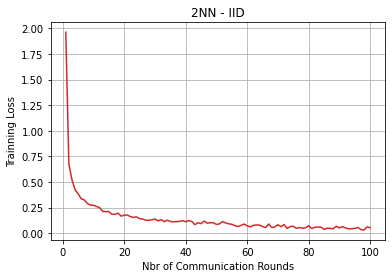

In [ ]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 5
# learning Rate
lr=0.03
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp_ = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp_.cuda()

mnist_mlp_iid_trained_ = training(mnist_mlp_, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "2NN - IID", "red")

# Test E=1

In [ ]:
criterion = nn.CrossEntropyLoss()
testing(mnist_mlp_iid_trained_, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.067458

Test Accuracy of     0: 97% (74/76)
Test Accuracy of     1: 96% (87/90)
Test Accuracy of     2: 97% (89/91)
Test Accuracy of     3: 97% (71/73)
Test Accuracy of     4: 98% (88/89)
Test Accuracy of     5: 97% (66/68)
Test Accuracy of     6: 96% (60/62)
Test Accuracy of     7: 97% (79/81)
Test Accuracy of     8: 100% (77/77)
Test Accuracy of     9: 97% (81/83)

Final Test  Accuracy: 97.722 (772.0/790.0)


## MNIST 2NN on Non IID

### Train E=5

Round: 1... 	Average Loss: 0.14
Round: 2... 	Average Loss: 0.078
Round: 3... 	Average Loss: 0.02
Round: 4... 	Average Loss: 0.027
Round: 5... 	Average Loss: 0.031
Round: 6... 	Average Loss: 0.033
Round: 7... 	Average Loss: 0.022
Round: 8... 	Average Loss: 0.022
Round: 9... 	Average Loss: 0.028
Round: 10... 	Average Loss: 0.013
Round: 11... 	Average Loss: 0.024
Round: 12... 	Average Loss: 0.019
Round: 13... 	Average Loss: 0.019
Round: 14... 	Average Loss: 0.011
Round: 15... 	Average Loss: 0.023
Round: 16... 	Average Loss: 0.022
Round: 17... 	Average Loss: 0.02
Round: 18... 	Average Loss: 0.013
Round: 19... 	Average Loss: 0.014
Round: 20... 	Average Loss: 0.024
Round: 21... 	Average Loss: 0.013
Round: 22... 	Average Loss: 0.01
Round: 23... 	Average Loss: 0.014
Round: 24... 	Average Loss: 0.012
Round: 25... 	Average Loss: 0.019
Round: 26... 	Average Loss: 0.013
Round: 27... 	Average Loss: 0.015
Round: 28... 	Average Loss: 0.012
Round: 29... 	Average Loss: 0.015
Round: 30... 	Average Loss:

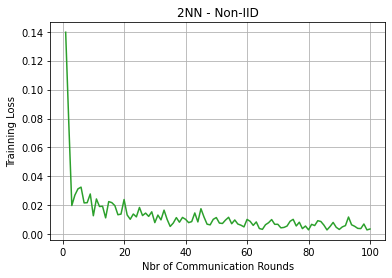

In [ ]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.05
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "2NN - Non-IID", "green")

### Test

In [ ]:
criterion = nn.CrossEntropyLoss()
testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.142849

Test Accuracy of     0: 97% (74/76)
Test Accuracy of     1: 95% (86/90)
Test Accuracy of     2: 92% (84/91)
Test Accuracy of     3: 91% (67/73)
Test Accuracy of     4: 100% (89/89)
Test Accuracy of     5: 95% (65/68)
Test Accuracy of     6: 96% (60/62)
Test Accuracy of     7: 98% (80/81)
Test Accuracy of     8: 100% (77/77)
Test Accuracy of     9: 85% (71/83)

Final Test  Accuracy: 95.316 (753.0/790.0)


# Train E=1

Round: 1... 	Average Loss: 0.317
Round: 2... 	Average Loss: 0.226
Round: 3... 	Average Loss: 0.154
Round: 4... 	Average Loss: 0.171
Round: 5... 	Average Loss: 0.163
Round: 6... 	Average Loss: 0.198
Round: 7... 	Average Loss: 0.155
Round: 8... 	Average Loss: 0.133
Round: 9... 	Average Loss: 0.146
Round: 10... 	Average Loss: 0.134
Round: 11... 	Average Loss: 0.142
Round: 12... 	Average Loss: 0.067
Round: 13... 	Average Loss: 0.159
Round: 14... 	Average Loss: 0.101
Round: 15... 	Average Loss: 0.104
Round: 16... 	Average Loss: 0.095
Round: 17... 	Average Loss: 0.072
Round: 18... 	Average Loss: 0.1
Round: 19... 	Average Loss: 0.084
Round: 20... 	Average Loss: 0.076
Round: 21... 	Average Loss: 0.109
Round: 22... 	Average Loss: 0.124
Round: 23... 	Average Loss: 0.084
Round: 24... 	Average Loss: 0.098
Round: 25... 	Average Loss: 0.097
Round: 26... 	Average Loss: 0.119
Round: 27... 	Average Loss: 0.042
Round: 28... 	Average Loss: 0.073
Round: 29... 	Average Loss: 0.097
Round: 30... 	Average Los

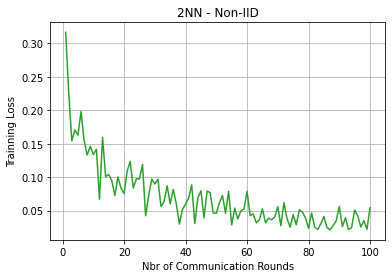

In [ ]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 1
# batch size
batch_size = 5
# learning Rate
lr=0.05
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp_ = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp_.cuda()

mnist_mlp_non_iid_trained_ = training(mnist_mlp_, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "2NN - Non-IID", "green")

# Test E=1

In [ ]:
criterion = nn.CrossEntropyLoss()
testing(mnist_mlp_non_iid_trained_, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 0.147550

Test Accuracy of     0: 100% (76/76)
Test Accuracy of     1: 97% (88/90)
Test Accuracy of     2: 98% (90/91)
Test Accuracy of     3: 95% (70/73)
Test Accuracy of     4: 92% (82/89)
Test Accuracy of     5: 89% (61/68)
Test Accuracy of     6: 95% (59/62)
Test Accuracy of     7: 92% (75/81)
Test Accuracy of     8: 97% (75/77)
Test Accuracy of     9: 97% (81/83)

Final Test  Accuracy: 95.823 (757.0/790.0)


# Summary of Experiments and Results

I ran 4 different experiments for the Federated Averaging Paper (Linked -> [here](https://arxiv.org/pdf/1602.05629.pdf)). 

You can look at the training graph with the training for each experiment above.
 
    **MNIST CNN**

      - IID Parition: (Test Accuracy 99.434%)
      - non-IID Parition: (Test Accuracy 98.734%)

    **MNIST MLP**
      - IID Parition: (Test Accuracy 97.848%)
      - non-IID Parition: (Tes0t Accuracy 94.684%)

---

### Observations

#### Model Architecture

The first thing that I observed here was, in the paper for the CNN architecture, the authors have reported that total parameters as **1,663,370**. After my implementation, the total parameters that I got were **582,026**

Authors, haven't used Dropout layers but I noticed a significant improvement in training with a single dropout layer after the second CNN layer with a drop probability of **0.2**.

#### Hyperparameters

Authors have reported the following hyperparameters for their CNN model 

    IID Partition
      - Learning Rate: 0.215
      - Local Epochs: 1, 5, 25, 50, 100, 200, 400
      - Local Batch Size: 10
      - Client Fraction: 0.1
      - Optimizer: SGD

    non-IID Partition
        - Learning Rate: 0.1
        - Local Epochs: 1, 5, 25, 50, 100, 200, 400
        - Local Batch Size: 10
        - Client Fraction: 0.1
        - Optimizer: SGD

I noted that, using the following hyperparameters, my network gets stuck in a local minima and doesn't converge. The learning rate used by the authors seems to be very high for deep learning task

*The hyperparameters that worked for me on CNN are the following*

    - Learning Rate: 0.01
    - Local Epochs: 5
    - Local Batch Size: 10
    - Client Fraction: 0.1
    - Optimizer: SGD


For CNN trained on non-IID data partition, with my hyperparameters, the test accuracy can be achieved with just 50 rounds of communication instead of 100.


For, MLP model, I noticed that with learning rate of **0.01**, the network was getting stuck in a local minima. I experimented with **0.03** and **0.05** learning rate that gave me better results on the MLP model
---

**Big thanks to https://github.com/SarodYatawatta/federated-pytorch-test for providing an easy to understand implementation of federated learning to get me started in this field.**